In [104]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [105]:
df=pd.read_csv('./jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [140]:
def univariate_data(dataset, start_idx, end_idx, history_size, target_size):
    data = []
    label = []
    
    start_idx = start_idx + history_size
    if end_idx is None:
        
        end_idx = len(dataset) - target_size
        
    for i in range(start_idx, end_idx):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices],(history_size,1)))
        label.append(dataset[i+target_size])
    return np.array(data), np.array(label)

In [141]:
train_split = 300000
tf.random.set_seed(13)

In [142]:
uni_data = df['Tdew (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.90
01.01.2009 00:20:00   -9.28
01.01.2009 00:30:00   -9.31
01.01.2009 00:40:00   -9.07
01.01.2009 00:50:00   -9.04
Name: Tdew (degC), dtype: float64

array([<AxesSubplot:xlabel='Date Time'>], dtype=object)

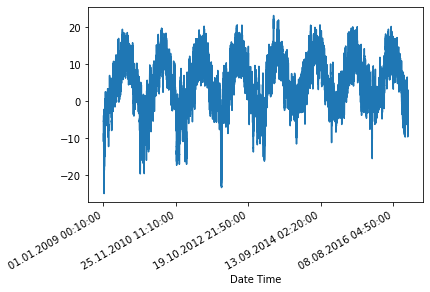

In [143]:
uni_data.plot(subplots=True)

In [144]:
uni_data = uni_data.values

In [145]:
uni_train_mean = uni_data[:train_split].mean()
uni_train_std = uni_data[:train_split].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std

In [146]:
x_train_uni, y_train_uni = univariate_data(uni_data, 0, train_split, 20, 0)
x_val_uni, y_val_uni = univariate_data(uni_data, train_split, None, 20, 0)

In [147]:
print(x_train_uni[0])
print(y_train_uni[0])

[[-1.95200996]
 [-2.00644103]
 [-2.01073822]
 [-1.9763607 ]
 [-1.97206352]
 [-1.93482121]
 [-1.86606618]
 [-1.87466056]
 [-1.92765922]
 [-2.01503541]
 [-2.0608721 ]
 [-2.07662846]
 [-2.06660168]
 [-2.06373689]
 [-2.03222417]
 [-2.03795375]
 [-2.04511573]
 [-2.0608721 ]
 [-2.06516929]
 [-2.08379044]]
-2.0809256463665595


In [148]:
def create_time_steps(length):
    return list(range(-length,0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0
    
    plt.title(title)
    for i , x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize= 10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
                
    plt.legend()
    plt.xlim([time_steps[0],(future+5)*2])
    plt.xlabel('Time Steps')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\smw56\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

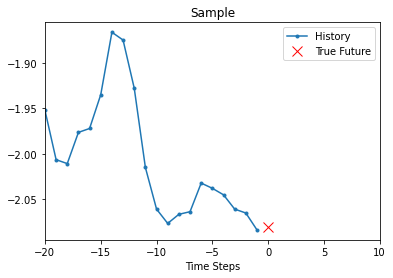

In [149]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample')

<module 'matplotlib.pyplot' from 'C:\\Users\\smw56\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

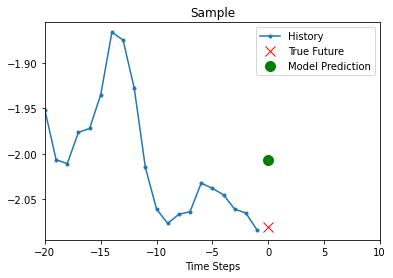

In [150]:
def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])],0, 'Sample')

In [151]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(256).batch(10000).repeat()

var_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
var_univariate = var_univariate.batch(256).repeat()

In [152]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape = x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mae')

In [153]:
for x, y in var_univariate.take(1):
        print(model.predict(x).shape)

(256, 1)


In [155]:
model.fit(train_univariate, epochs=10, steps_per_epoch=200, validation_data = var_univariate,validation_steps=50)

Epoch 1/10
200/200 [==============================] - 34s 168ms/step - loss: 0.3736 - val_loss: 0.1099
Epoch 2/10
200/200 [==============================] - 32s 162ms/step - loss: 0.1175 - val_loss: 0.0370
Epoch 3/10
200/200 [==============================] - 32s 160ms/step - loss: 0.0553 - val_loss: 0.0308
Epoch 4/10
200/200 [==============================] - 32s 162ms/step - loss: 0.0428 - val_loss: 0.0280
Epoch 5/10
200/200 [==============================] - 37s 184ms/step - loss: 0.0368 - val_loss: 0.0263
Epoch 6/10
200/200 [==============================] - 37s 183ms/step - loss: 0.0333 - val_loss: 0.0243
Epoch 7/10
200/200 [==============================] - 32s 162ms/step - loss: 0.0308 - val_loss: 0.0232
Epoch 8/10
200/200 [==============================] - 32s 162ms/step - loss: 0.0286 - val_loss: 0.0214
Epoch 9/10
200/200 [==============================] - 33s 163ms/step - loss: 0.0271 - val_loss: 0.0206
Epoch 10/10
200/200 [==============================] - 32s 162ms/step - l

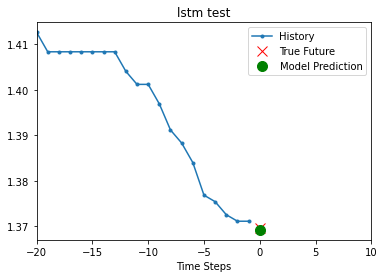

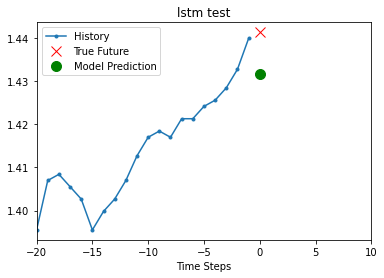

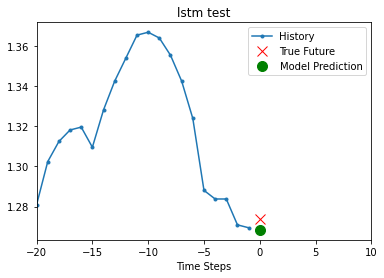

In [156]:
for x,y in var_univariate.take(3):
    plot=show_plot([x[0].numpy(),y[0].numpy(),model.predict(x)[0]],0,'lstm test')
    plot.show()

In [157]:
feature_con =['p (mbar)', 'T (degC)', 'rho (g/m**3)'] ##기압 온도 밀도
feature = df[feature_con]
feature.index = df['Date Time']
feature.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

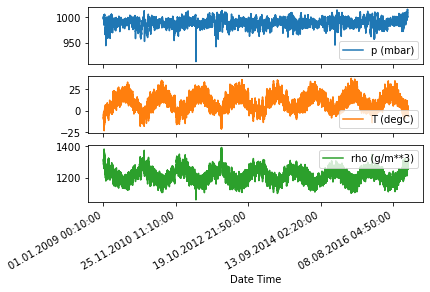

In [162]:
feature.plot(subplots=True)

In [163]:
dataset = feature.values
data_mean = dataset[:train_split].mean(axis=0)
data_std = dataset[:train_split].std(axis=0)
dataset = (dataset-data_mean) / data_std

In [170]:
def multivariate_data(dataset, target, start_idx, end_idx, history_size, target_size, step, single_step=False):
    data = []
    label = []
    
    start_idx = start_idx + history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size
        
    for i in range(start_idx, end_idx):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            label.append(target[i+target_size])
        else:
            label.append(target[i:i+target_size])
            
    return np.array(data), np.array(label)

In [171]:
x_train_single, y_train_single = multivariate_data(dataset, dataset[:,1], 0, train_split, 720, 72, 6, single_step = True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,1], train_split, None, 720, 72, 6, single_step = True)

In [172]:
print(x_train_single[0].shape)

(120, 3)


In [174]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(10000).batch(256).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(256).repeat()

In [175]:
single_model = tf.keras.models.Sequential()
single_model.add(tf.keras.layers.LSTM(32,input_shape=x_train_single.shape[-2:]))
single_model.add(tf.keras.layers.Dense(1))
single_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')

In [176]:
single_history = single_model.fit(train_data_single, epochs=10, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 45s 224ms/step - loss: 0.1496 - val_loss: 0.1174
Epoch 2/10
200/200 [==============================] - 50s 249ms/step - loss: 0.1119 - val_loss: 0.1052
Epoch 3/10
200/200 [==============================] - 57s 286ms/step - loss: 0.1076 - val_loss: 0.0981
Epoch 4/10
200/200 [==============================] - 68s 338ms/step - loss: 0.1052 - val_loss: 0.0925
Epoch 5/10
200/200 [==============================] - 80s 400ms/step - loss: 0.0844 - val_loss: 0.0852
Epoch 6/10
200/200 [==============================] - 81s 404ms/step - loss: 0.0951 - val_loss: 0.1161
Epoch 7/10
200/200 [==============================] - 81s 407ms/step - loss: 0.0959 - val_loss: 0.0981
Epoch 8/10
200/200 [==============================] - 80s 402ms/step - loss: 0.0974 - val_loss: 0.0977
Epoch 9/10
200/200 [==============================] - 80s 401ms/step - loss: 0.0936 - val_loss: 0.0931
Epoch 10/10
200/200 [==============================] - 81s 403ms/step - l

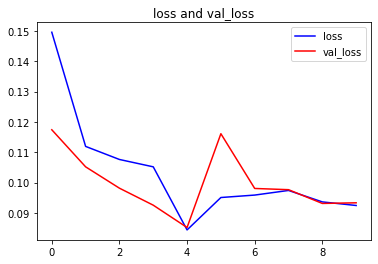

In [179]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label = 'loss')
    plt.plot(epochs, val_loss, 'r', label = 'val_loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_train_history(single_history, 'loss and val_loss')

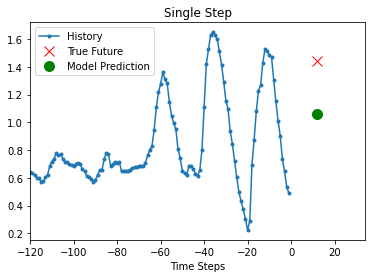

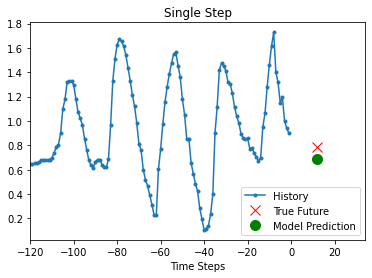

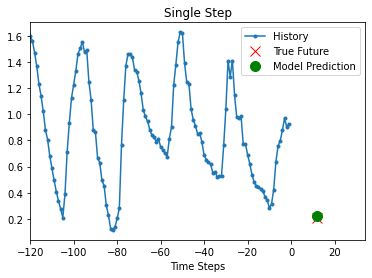

In [181]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:,1].numpy(), y[0].numpy(),single_model.predict(x)[0]],12,'Single Step')
    plot.show()